In [1]:
import geopandas as gpd
from geopandas.tools import sjoin


In [2]:
#import datasets
voronoi = gpd.read_file('datos/voronoi_escuelas_secundarias_AMBA.shp')
AMBA_datos_persona_13_18 = gpd.read_file('datos/AMBA_datos_persona_13_18.shp')

In [3]:

intersections= gpd.sjoin(voronoi, AMBA_datos_persona_13_18, how="right", op='intersects').reset_index()
df = intersections.merge(voronoi.reset_index(), on = 'index_left')
df.rename(columns = {'index_right': 'index_radio', 'index_left': 'index_voronoi'}, inplace=True)

In [4]:
df['intersect_portion'] = ""
df['geometry'] = ""

for i, row in df.iterrows():
    df.set_value(i,'geometry', row['geometry_x'].intersection(row['geometry_y']))
    df.set_value(i,'intersect_portion', row['geometry_x'].intersection(row['geometry_y']).area/(row['geometry_x'].area))
    
df_intersect = df[['index_voronoi','index_radio']].join(df[['varon','mujer','totalpobl','hogares','persona_13','area_km2']].apply(lambda col: col.mul(df['intersect_portion'])))
df_intersect.set_index(['index_voronoi','index_radio'], inplace=True)
df_intersect = df_intersect.add_prefix('intersect_')
df_intersect['geometry'] = df['geometry'].values
df_intersect['intersect_portion'] = df['intersect_portion'].values

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [5]:
inters_cols = [col for col in df_intersect.columns if 'intersect_' in col]

voronoi_aggregation = df_intersect[inters_cols].groupby( level=['index_voronoi']).sum()
voronoi_aggregation.columns = [u'voronoi_varon', u'voronoi_mujer', u'voronoi_totalpobl',
       u'voronoi_hogares', u'voronoi_persona_13_18',
       u'voronoi_area_km2']

densidad = df.groupby('index_radio')['densidad'].mean().to_frame()
plot_data = df_intersect.join(voronoi_aggregation).join(densidad)[['geometry', 'voronoi_persona_13_18','densidad']]
plot_data = gpd.GeoDataFrame(plot_data)

/home/miglesia/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
/home/miglesia/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:255: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


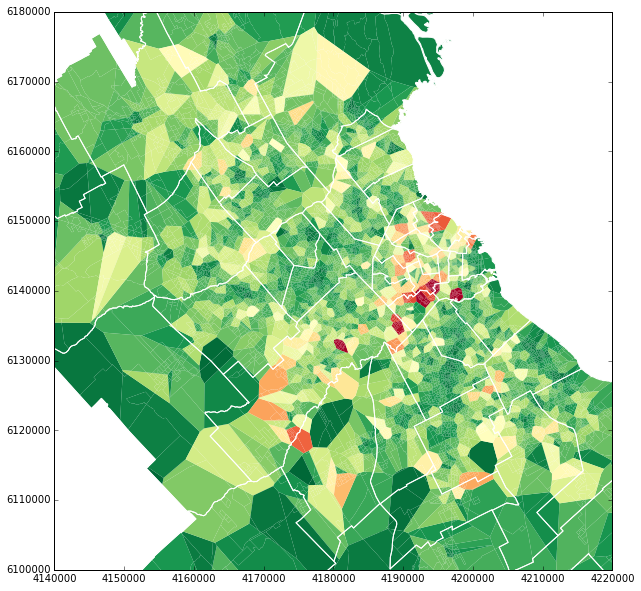

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

partidos = gpd.read_file('datos/partidos.shp')
CABA_datos= gpd.read_file('datos/CABA_datos.shp')

plot_data['-voronoi_persona_13_18'] = -plot_data['voronoi_persona_13_18']

f, ax = plt.subplots(1, figsize=(10, 10))
plot_data.plot(column = '-voronoi_persona_13_18', axes = ax, edgecolors = 'None', vmin = -3000, vmax = 0, cmap = 'RdYlGn')
partidos['geometry'].plot(axes=ax, color = 'None', edgecolor = 'w')
CABA_datos.dissolve(by = 'depto')['geometry'].plot(axes=ax, color = 'None', edgecolor = 'w')

plt.xlim(4140000, 4220000)
plt.ylim(6100000, 6180000)

plt.show()